# Implementing a Feed-Forward Neural Network from Scratch

## Section 1: Exploring and optimizing neural network hyperparameters

In [132]:
# Code in this cell provided by course instructor

# Optional for clear plotting on Macs
%config InlineBackend.figure_format='retina'

# Some of the network training leads to warnings. When we know and are OK with 
#  what's causing the warning and simply don't want to see it, we can use the 
#  following code. Run this block
#  to disable warnings
import sys
import os
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = 'ignore'

In [133]:
# Code in this cell provided by course instructor

import numpy as np
from sklearn.model_selection import PredefinedSplit
from matplotlib.colors import ListedColormap
from sklearn.neural_network import MLPClassifier

#-----------------------------------------------------------------------------
# Create the data
#-----------------------------------------------------------------------------
# Data generation function to create a checkerboard-patterned dataset
def make_data_normal_checkerboard(n, noise=0):
    n_samples = int(n/4)
    shift = 0.5
    c1a = np.random.randn(n_samples,2)*noise + [-shift, shift]
    c1b = np.random.randn(n_samples,2)*noise + [shift, -shift]
    c0a = np.random.randn(n_samples,2)*noise + [shift, shift]
    c0b = np.random.randn(n_samples,2)*noise + [-shift, -shift]
    X = np.concatenate((c1a,c1b,c0a,c0b),axis=0)
    y = np.concatenate((np.ones(2*n_samples), np.zeros(2*n_samples)))
    
    # Set a cutoff to the data and fill in with random uniform data:
    cutoff = 1.25
    indices_to_replace = np.abs(X)>cutoff
    for index,value in enumerate(indices_to_replace.ravel()):
        if value:
            X.flat[index] = np.random.rand()*2.5-1.25
    return (X,y)

# Training datasets
np.random.seed(42)
noise = 0.45
X_train,y_train = make_data_normal_checkerboard(500, noise=noise)
    
# Validation and test data
X_val,y_val = make_data_normal_checkerboard(500, noise=noise)
X_test,y_test = make_data_normal_checkerboard(500, noise=noise)

# For RandomSeachCV, we will need to combine training and validation sets then
#  specify which portion is training and which is validation
# Also, for the final performance evaluation, train on all of the training AND validation data
X_train_plus_val = np.concatenate((X_train, X_val), axis=0)
y_train_plus_val = np.concatenate((y_train, y_val), axis=0)

# Create a predefined train/test split for RandomSearchCV (to be used later)
validation_fold = np.concatenate((-1*np.ones(len(y_train)), np.zeros(len(y_val))))
train_val_split = PredefinedSplit(validation_fold)

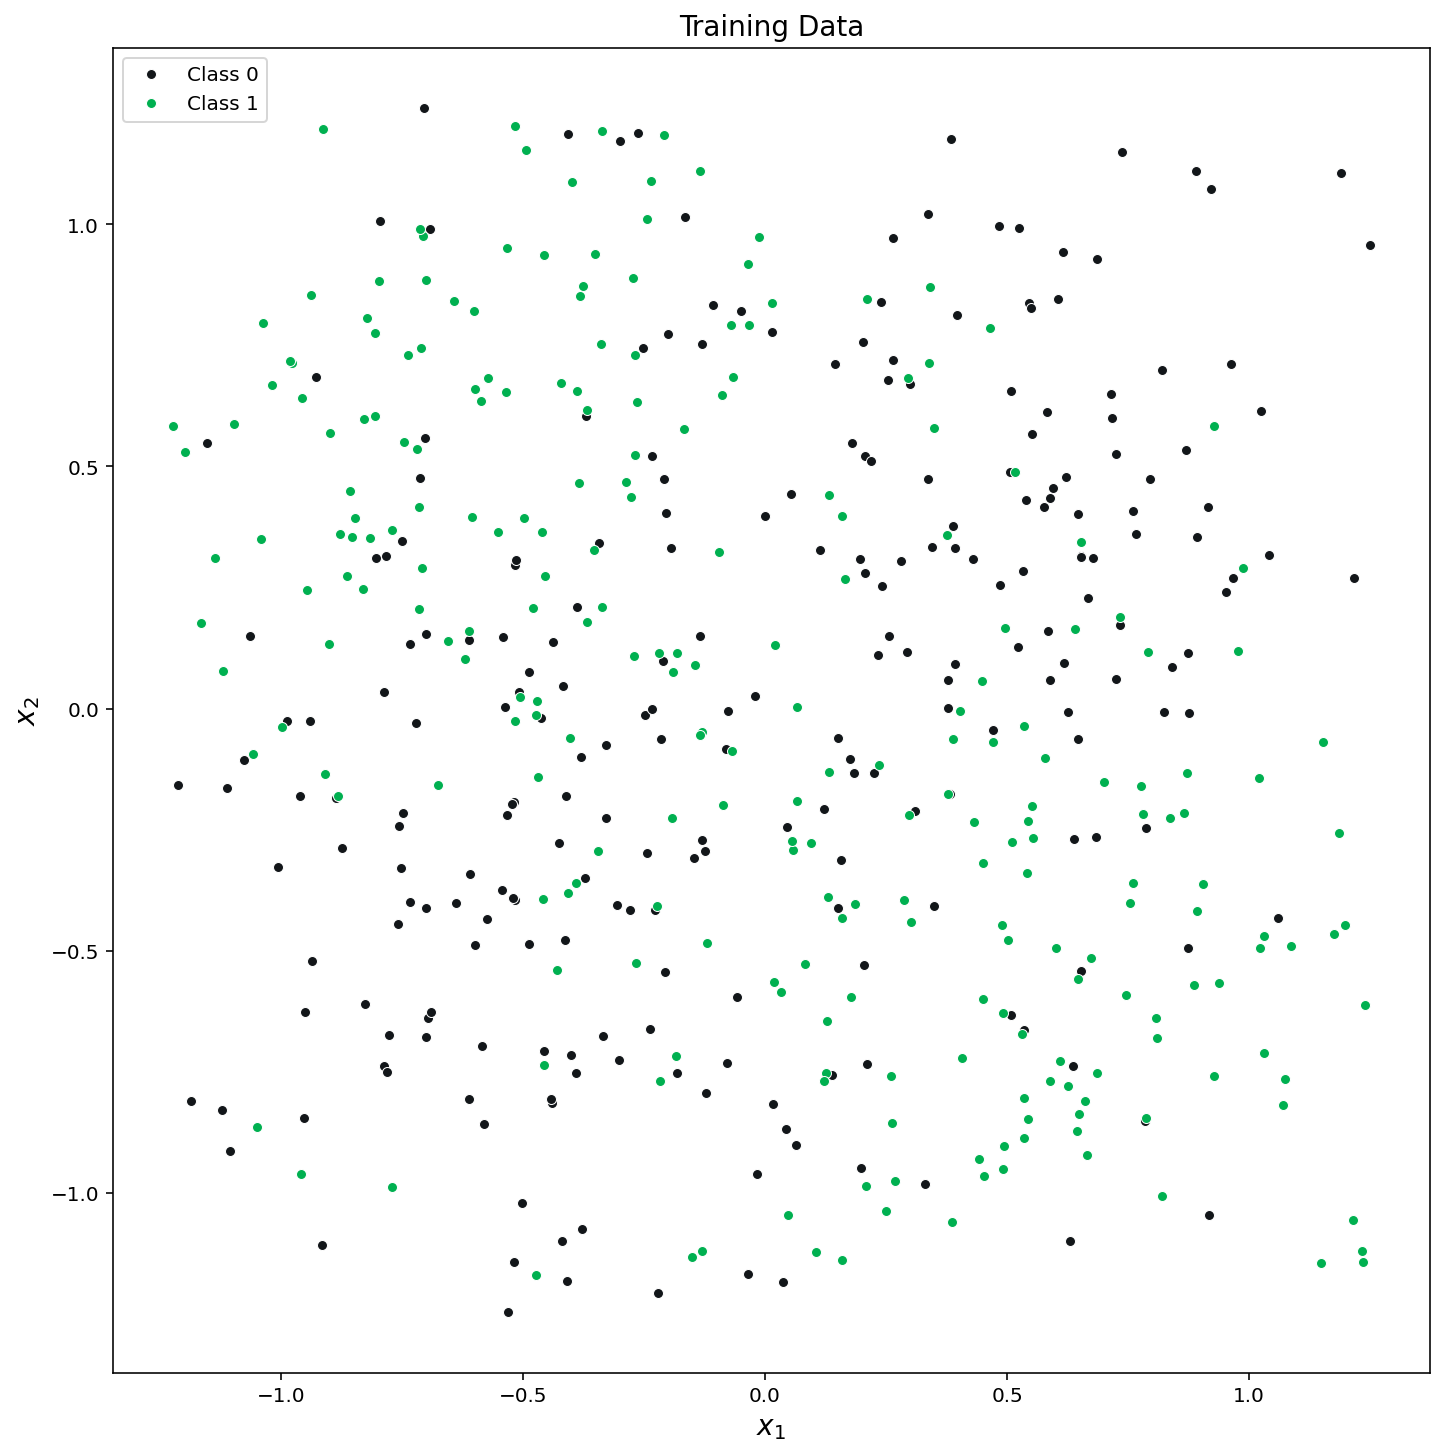

In [134]:
# Code in this cell provided by course instructor

import matplotlib.pyplot as plt

# Code to plot the sample data
def plot_data(ax,X,y,title, limits):
    # Select the colors to use in the plots
    color0 = '#121619' # Dark grey
    color1 = '#00B050' # Green
    color_boundary='#858585'
    
    # Separate samples by class
    samples0 = X[y==0]
    samples1 = X[y==1]

    ax.plot(samples0[:,0],samples0[:,1],
        marker='o',
        markersize=5,
        linestyle="None",
        color=color0,
        markeredgecolor='w',
        markeredgewidth=0.5,
        label='Class 0')
    ax.plot(samples1[:,0],samples1[:,1],
        marker='o',
        markersize=5,
        linestyle="None",
        color=color1,
        markeredgecolor='w',
        markeredgewidth=0.5,
        label='Class 1')
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('$x_1$', fontsize=14)
    ax.set_ylabel('$x_2$', fontsize=14)
    ax.legend(loc='upper left')
    ax.set_aspect('equal')

fig, ax = plt.subplots(constrained_layout=True, figsize=(10,10))
limits = [-1.25, 1.25, -1.25, 1.25]
plot_data(ax, X_train, y_train, 'Training Data', limits)

### (a) Visualize the impact of different hyperparameter choices on classifier decision boundaries

In [4]:
# Make list of all default hyperparameters
default_hyperparams = [0.03,
                       (30, 30),
                       0,
                       "sgd",
                       1e-5,
                       False,
                       "relu",
                       1000,
                       50,
                       500]

def make_new_default_model(default):
    """Instantiate a MLPClassifier with the deafult hyperparameters
    
    Parameters
    ----------
    default: list
        the default hyperparameters for the NN
    
    Returns
    ----------
    Untrained MLPClassifier object with the default hyperparameters
    """
    
    return MLPClassifier(learning_rate_init=default[0],
                         hidden_layer_sizes=default[1],
                         alpha=default[2],
                         solver=default[3],
                         tol=default[4],
                         early_stopping=default[5],
                         activation=default[6],
                         n_iter_no_change=default[7],
                         batch_size=default[8],
                         max_iter=default[9])

In [5]:
# 3 models with varying layer architecture
mlp_layers_2_2 = make_new_default_model(default_hyperparams)
mlp_layers_2_2.hidden_layer_sizes = (2, 2)

mlp_layers_5_5 = make_new_default_model(default_hyperparams)
mlp_layers_5_5.hidden_layer_sizes = (5, 5)

mlp_layers_30_30 = make_new_default_model(default_hyperparams)
mlp_layers_30_30.hidden_layer_sizes = (30, 30)


# 3 models with varying learning rates
mlp_lri_0001 = make_new_default_model(default_hyperparams)
mlp_lri_0001.learning_rate_init = 0.0001

mlp_lri_01 = make_new_default_model(default_hyperparams)
mlp_lri_01.learning_rate_init = 0.01

mlp_lri_1 = make_new_default_model(default_hyperparams)
mlp_lri_1.learning_rate_init = 1


# 3 models with varying regularization penalties
mlp_reg_0 = make_new_default_model(default_hyperparams)
mlp_reg_0.alpha = 0

mlp_reg_1 = make_new_default_model(default_hyperparams)
mlp_reg_1.alpha = 1

mlp_reg_10 = make_new_default_model(default_hyperparams)
mlp_reg_10.alpha = 10


# 3 model with varying batch size
mlp_batch_5 = make_new_default_model(default_hyperparams)
mlp_batch_5.batch_size = 5

mlp_batch_50 = make_new_default_model(default_hyperparams)
mlp_batch_50.batch_size = 50

mlp_batch_500 = make_new_default_model(default_hyperparams)
mlp_batch_500.batch_size = 500

In [6]:
# Training all the models

models = [mlp_layers_2_2, mlp_layers_5_5, mlp_layers_30_30,
          mlp_lri_0001, mlp_lri_01, mlp_lri_1,
          mlp_reg_0, mlp_reg_1, mlp_reg_10,
          mlp_batch_5, mlp_batch_50, mlp_batch_500]

for model in models:
    model.fit(X_train, y_train)

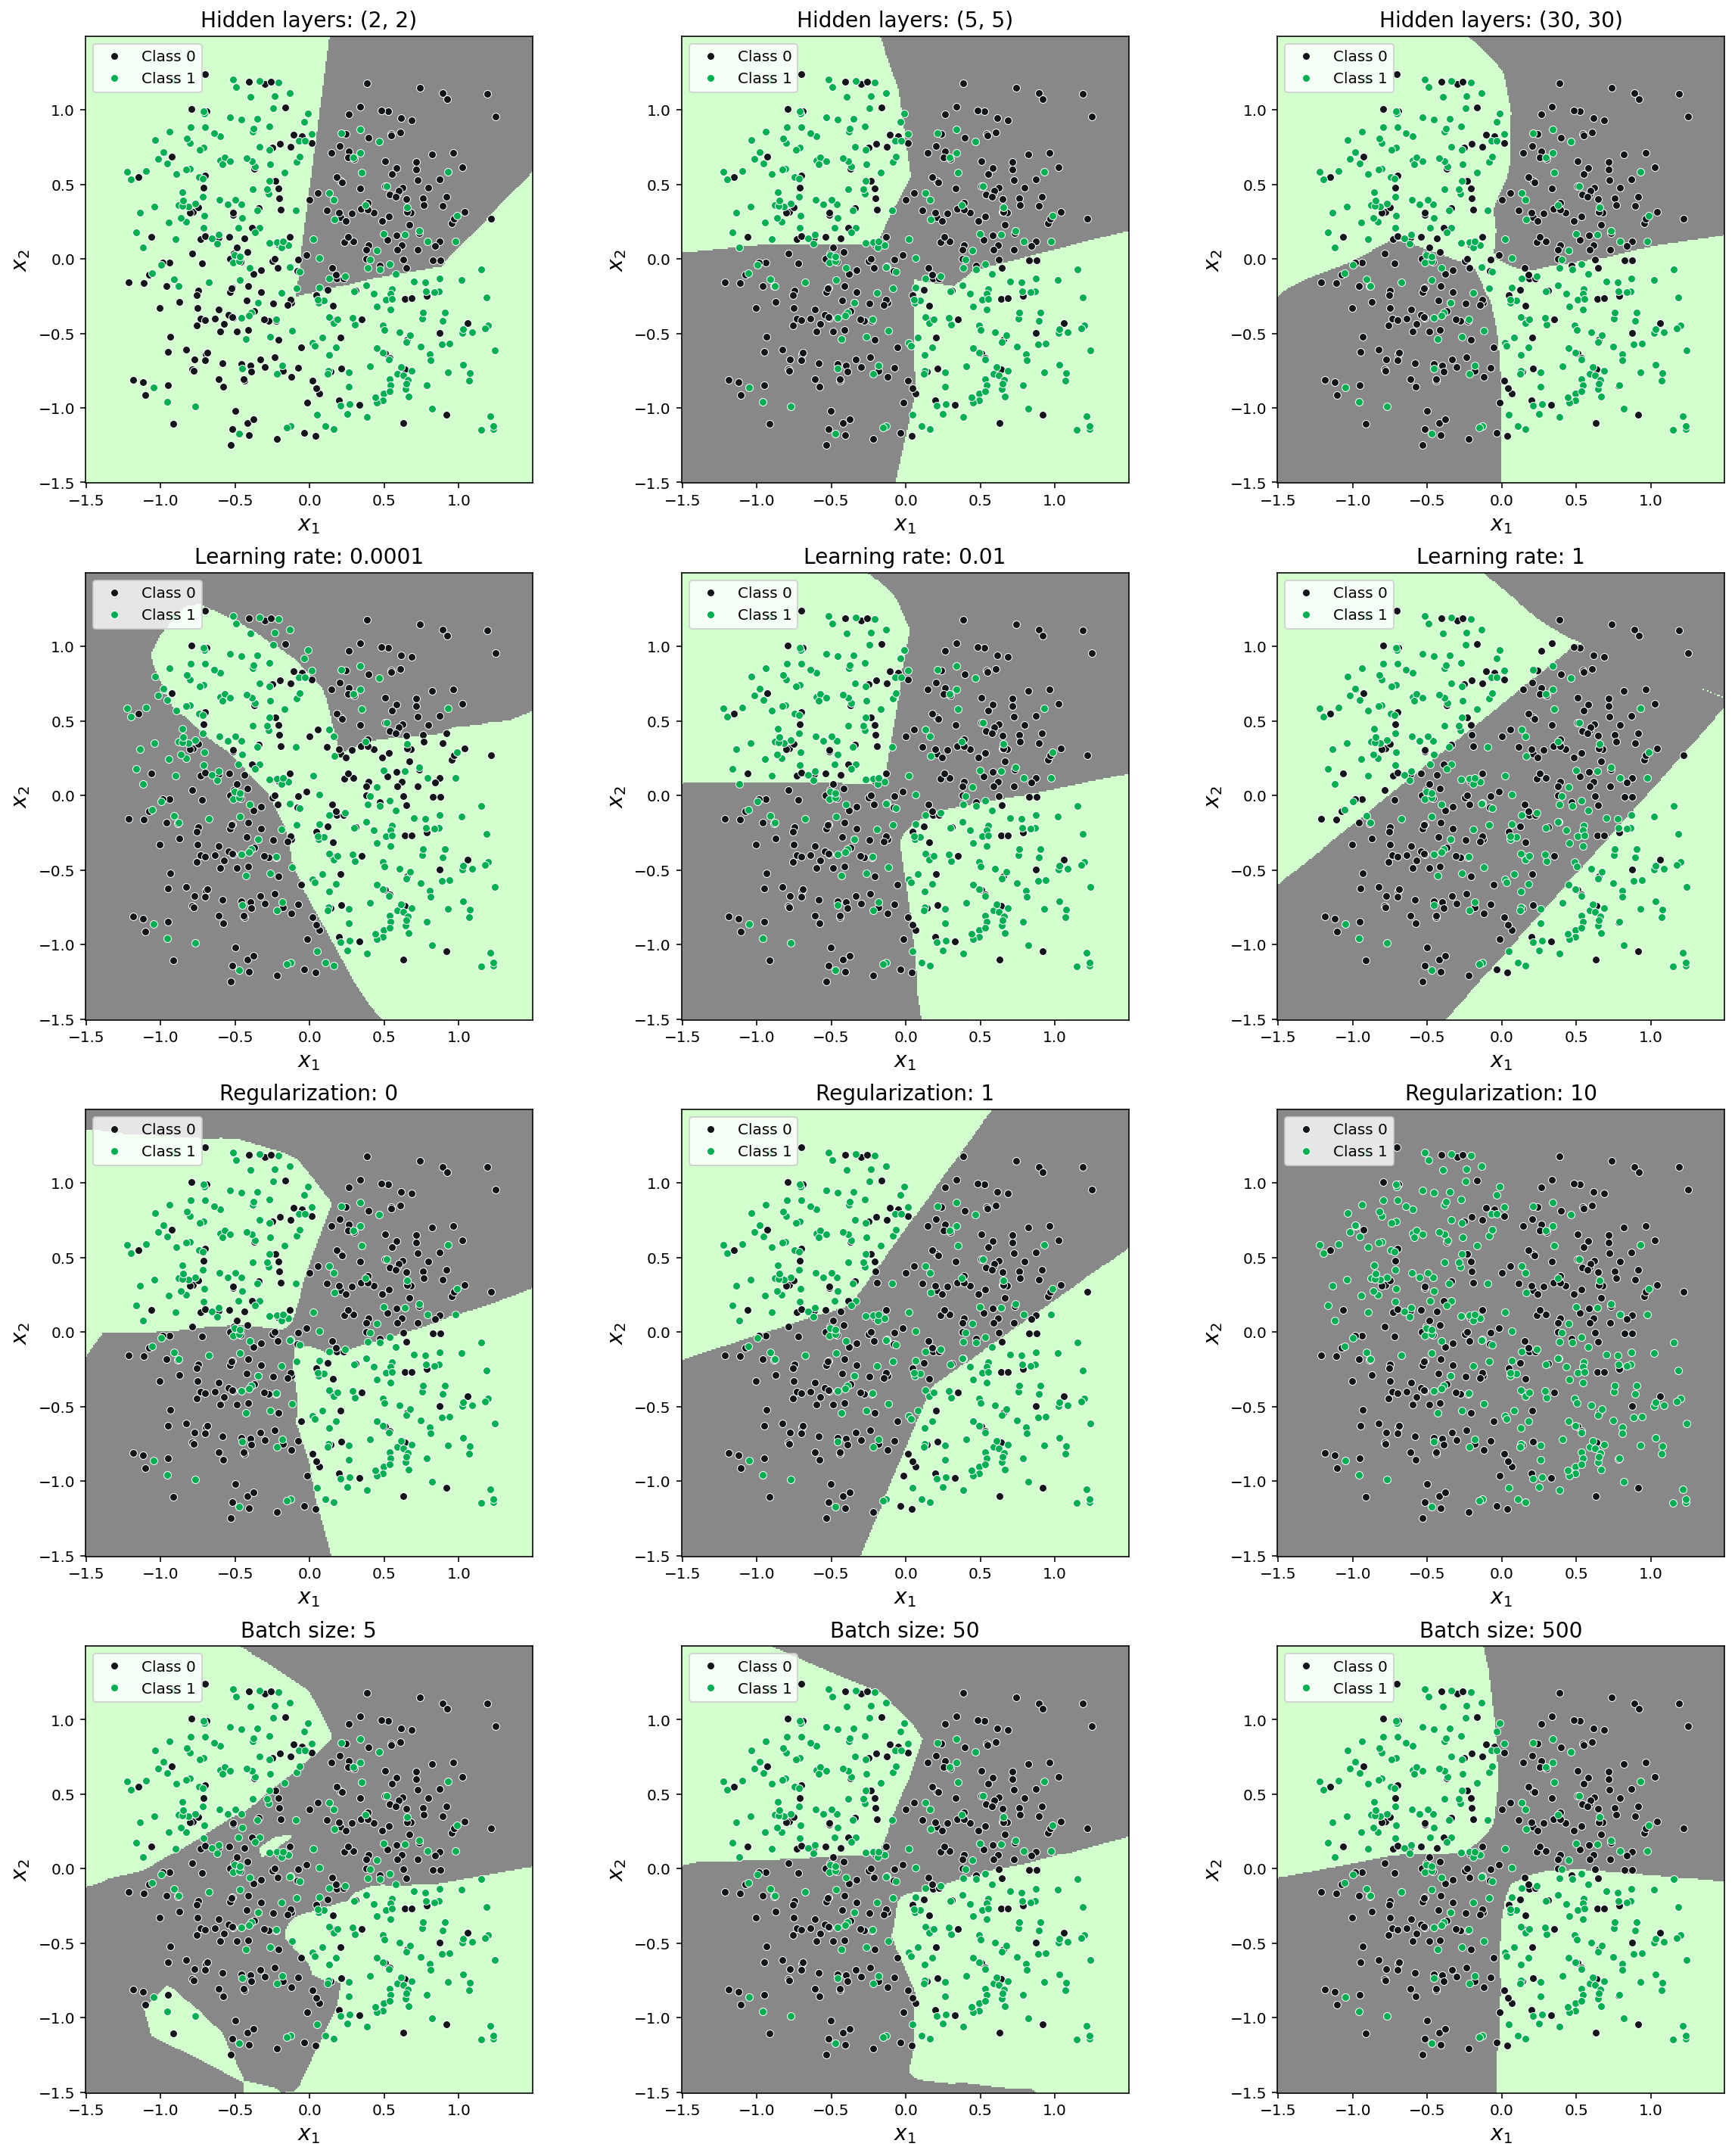

In [7]:
# Plotting

# First, plot the training data on every axis in the 4x3 grid of axes
fig, ax = plt.subplots(4, 3, figsize=(20, 25))

axes = [ax[0,0], ax[0,1], ax[0,2],
        ax[1,0], ax[1,1], ax[1,2],
        ax[2,0], ax[2,1], ax[2,2],
        ax[3,0], ax[3,1], ax[3,2]]

titles = ["Hidden layers: (2, 2)", "Hidden layers: (5, 5)", "Hidden layers: (30, 30)",
          "Learning rate: 0.0001", "Learning rate: 0.01", "Learning rate: 1",
          "Regularization: 0", "Regularization: 1", "Regularization: 10",
          "Batch size: 5", "Batch size: 50", "Batch size: 500"]

for i in range(12):
    plot_data(axes[i], X_train, y_train, titles[i], limits)
    
# Now let's plot decision boundaries
cmap = ListedColormap(["#888888", "#d3ffce"])

# Create a mesh
x_min = -1.5
x_max = 1.5
y_min = -1.5
y_max = 1.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
grid = np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)

# Plot decision boundaries
for i in range(12):
    axes[i].pcolormesh(xx, yy, models[i].predict(grid).reshape(xx.shape), cmap=cmap)

### (b) Manual (greedy) hyperparameter tuning I: manually optimize hyperparameters that govern the learning process, one hyperparameter at a time

In [8]:
def vary_hyperparameter_get_accuracy(hyp_param_name, hyp_param_values):
    """Examine how varying the value of a specified hyperparameter of the NN
    affects model accuracy for validation set
    
    Parameters
    ----------
    hyp_param_name: string
        the name of the hyperparameter of MLPClassifier we want to vary
    
    hyp_param_values: list
        The values of the hyperparameter that we want to try
    
    Returns
    ----------
    List of average model accuracies on validation set, one accuracy score for each value
    in hyp_param_values.
    """
    
    accuracy_scores = []
    for value in hyp_param_values:
        # For each value, train the model 5 times (no random seed)
        #.  Compute accuracy. Leter, we will average all 10 scores.
        scores_to_average = []
        for i in range(5):
            model = make_new_default_model(default_hyperparams)
            # Thank you to Deekshita for the following edits!
            # Previously, the following conditionals were replaced with:
            #.  model.hyp_param_name = value
            if hyp_param_name == "learning_rate_init":
                model.learning_rate_init = value
            elif hyp_param_name == "alpha":
                model.alpha = value
            elif hyp_param_name == "batch_size":
                model.batch_size = value
            else:
                pass
            model.fit(X_train, y_train)
            accuracy = model.score(X_val, y_val)
            scores_to_average.append(accuracy)
        avg_score = sum(scores_to_average) / len(scores_to_average)
        accuracy_scores.append(avg_score)
    return accuracy_scores

In [9]:
# Make lists of values of each hyperparameter we want to try
learning_rates = np.logspace(-5, 0, 20)
regs = np.logspace(-8, 2, 20)
batch_sizes = [1, 3, 5, 10, 20, 50, 100, 250, 500]

# Calculate avg validation accuracies for each value of each hyperparameter
accuracies_varying_lr = vary_hyperparameter_get_accuracy("learning_rate_init", learning_rates)

accuracies_varying_reg = vary_hyperparameter_get_accuracy("alpha", regs)

accuracies_varying_batch_size = vary_hyperparameter_get_accuracy("batch_size", batch_sizes)

In [10]:
def plot_accuracies_varying_hyperparameter(title, xlabel, param_vals, accuracy_vals, color):
    """Plot the average accuracies on the validation set as a function of a
    specified hyperparameter
    
    Parameters
    ----------
    title: string
        the title of the plot
    
    xlabel: string
        the label on the x-axis of the plot
    
    param_vals: list
        the different values of the hyperparameter used to obtain the avg accuracy scores
    
    accuracy_vals: list
        the list of average accuracies, one for each value in param_vals
    
    color: string
        the color of the line plot
    
    Returns
    ----------
    Nothing - just plots the data
    
    """
    
    plt.figure(figsize=(8, 8))
    plt.xscale("log")
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel("Validation accuracy", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.plot(param_vals,
             accuracy_vals,
             linewidth=8,
             color=color);

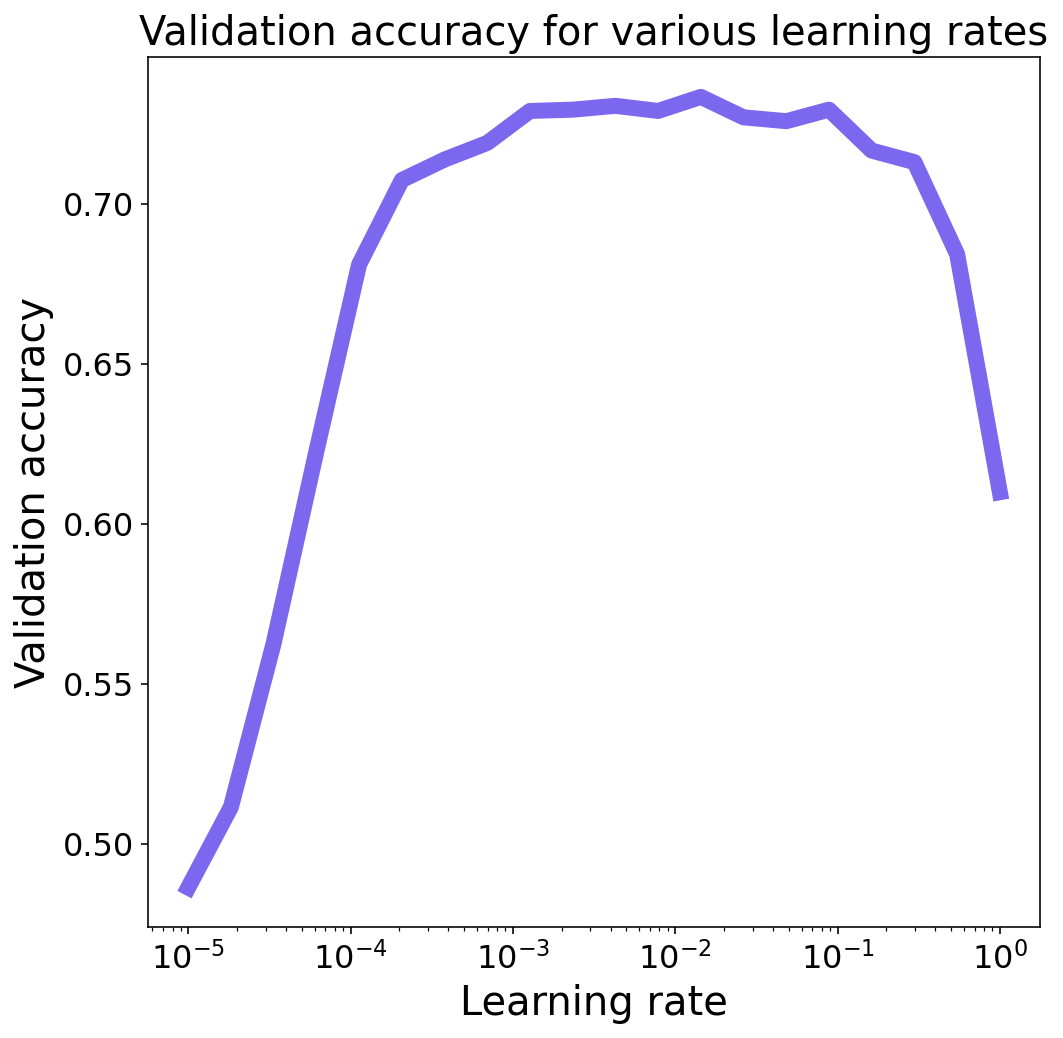

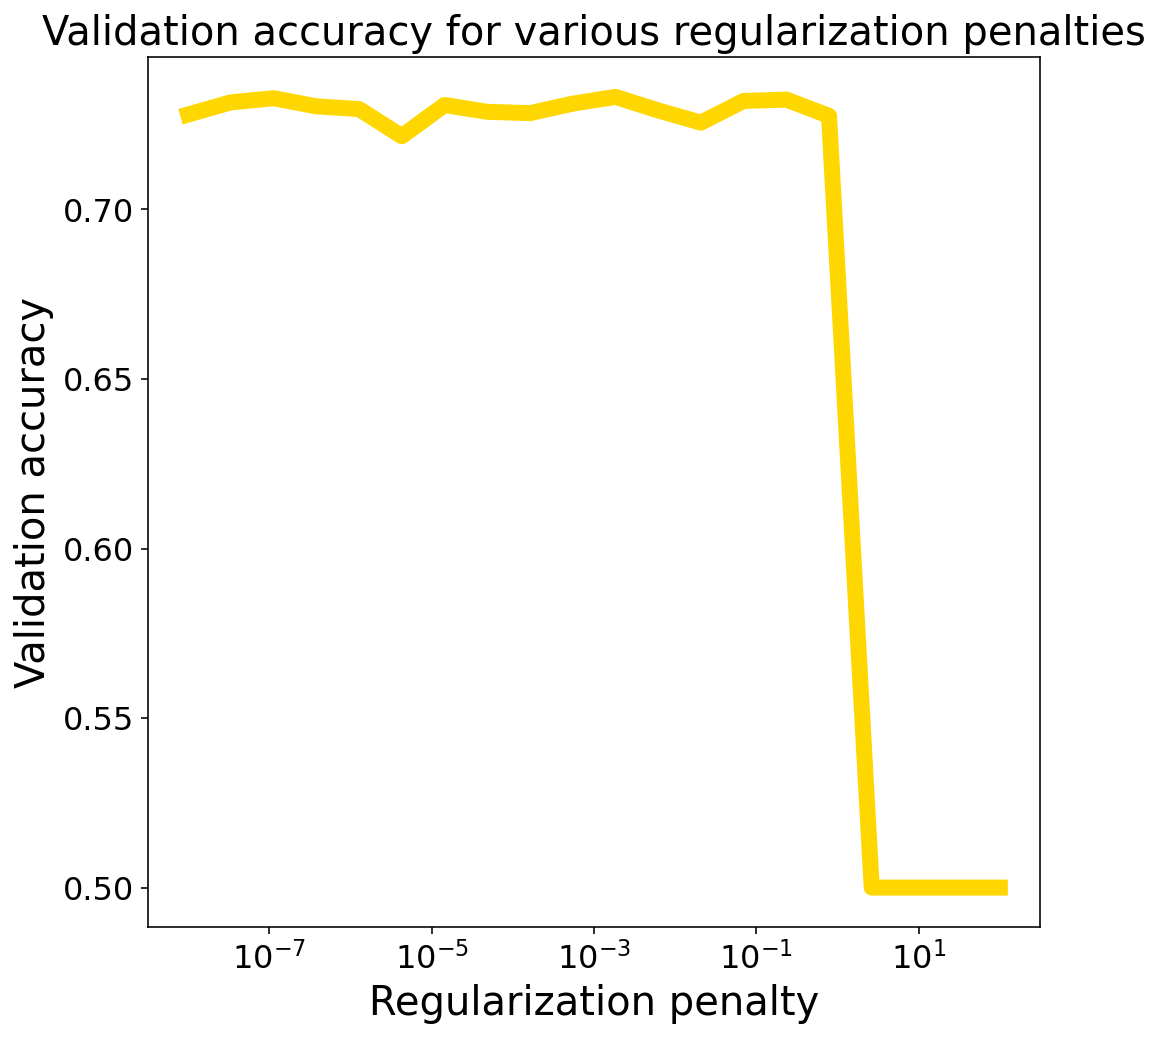

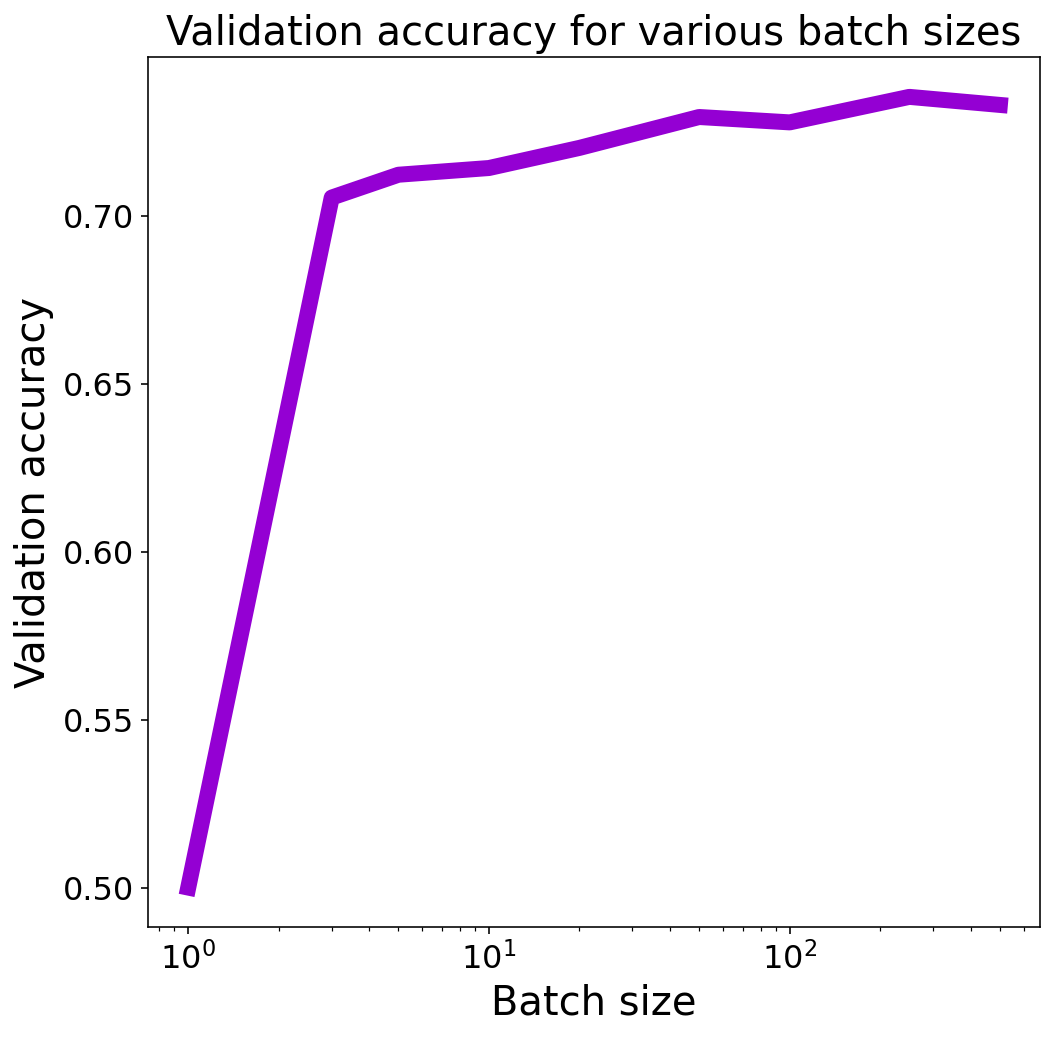

In [11]:
# Create all three plots
plot_accuracies_varying_hyperparameter("Validation accuracy for various learning rates",
                                       "Learning rate", learning_rates, accuracies_varying_lr,
                                       "mediumslateblue")

plot_accuracies_varying_hyperparameter("Validation accuracy for various regularization penalties",
                                       "Regularization penalty", regs, accuracies_varying_reg,
                                       "gold")

plot_accuracies_varying_hyperparameter("Validation accuracy for various batch sizes",
                                       "Batch size", batch_sizes, accuracies_varying_batch_size,
                                       "darkviolet")

<font size="4">The plots above give a good picture of how each hyperparameter affects accuracy,
but it's a bit difficult to tell exactly which values achieve optimal results
just by looking at the graphs.

<font size="4">Let's examine the lists of accuracies and see which choices of hyperparameter
values result in optimal performance

In [12]:
# Convert avg accuracies from lists to numpy arrays
arr_lr = np.array(accuracies_varying_lr)
arr_reg = np.array(accuracies_varying_reg)
arr_bs = np.array(accuracies_varying_batch_size)

# Find the index of the maximum avg accuracy for each hyperparameter
lr_max_acc = arr_lr.argmax()
reg_max_acc = arr_reg.argmax()
bs_max_acc = arr_bs.argmax()

# Find the optimal value of each hyperparameter from the list of values we tried
lr_optimal = learning_rates[lr_max_acc]
reg_optimal = regs[reg_max_acc]
bs_optimal = batch_sizes[bs_max_acc]

# Update the list of default hyperparameters with these optimal values
default_hyperparams[0] = lr_optimal
default_hyperparams[2] = reg_optimal
default_hyperparams[8] = bs_optimal

### (c) Manual (greedy) hyperparameter tuning II: manually optimize hyperparameters that impact the model architecture

In [13]:
# Get all possible pairs for the numbers of nodes per layer and
#.  numbers of layers that we want to try
nodes_per_layer = [1, 2, 3, 4, 5, 10, 15, 25, 30]
num_layers = [1, 2, 3, 4]

node_layer_pairs = []

for n in nodes_per_layer:
    for k in num_layers:
        node_layer_pairs.append((n, k))

In [14]:
def vary_NN_architecture_get_accuracies(pairs):
    """See how different choices of values for number of nodes per layer
    and number of layers affects MLPClassifier performance on validation set
    
    Parameters
    ----------
    pairs: list of tuples
        The different model architectures we want to try
        The first element of each tuple is the number of nodes per layer
            (each layer always has the same number of nodes)
        The second element of each tuple is the number of layers
    
    Returns
    ----------
    List of validation accuracies, one for each pair in pairs
    """
    
    accuracy_scores = []
    for pair in pairs:
        scores_to_average = []
        for i in range(5):
            nodes_per_layer = pair[0]
            num_layers = pair[1]
            # Create list of length num_layers filled with copies of n
            architecture = [nodes_per_layer for i in range(num_layers)]
            # Convert list to tuple so we can pass it to constructor for MLPClassifier
            architecture = tuple(architecture)
            model = make_new_default_model(default_hyperparams)
            model.hidden_layer_sizes = architecture
            model.fit(X_train, y_train)
            accuracy = model.score(X_val, y_val)
            scores_to_average.append(accuracy)
        avg_accuracy = sum(scores_to_average) / len(scores_to_average)
        accuracy_scores.append(round(avg_accuracy, 2))
    return accuracy_scores

In [15]:
accuracies_varying_architecture = vary_NN_architecture_get_accuracies(node_layer_pairs)

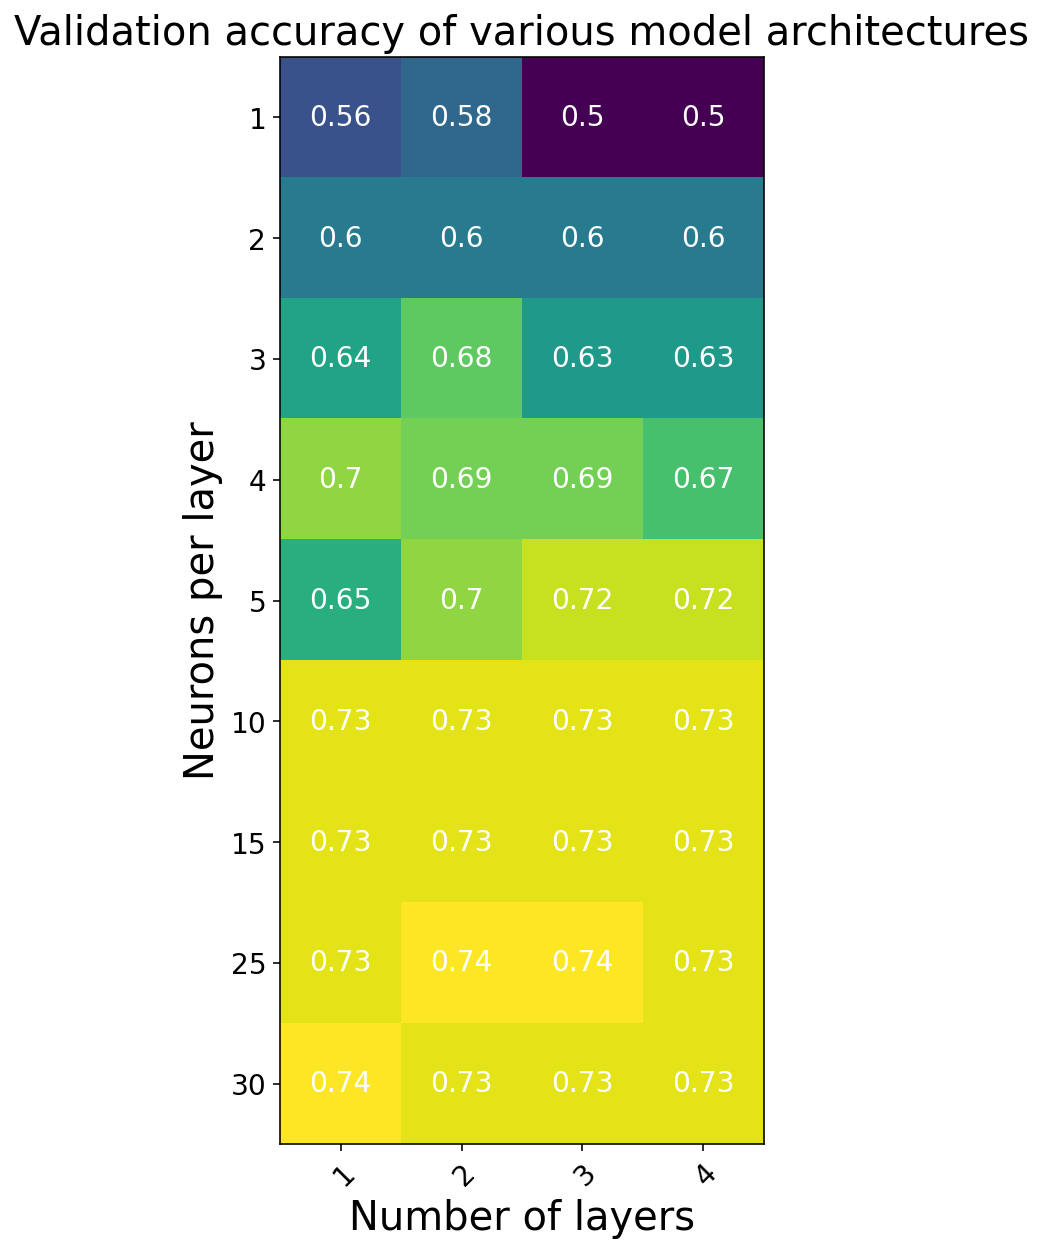

In [16]:
# Code in this cell was copied from the given URL and modified to fit this particular task

# Create a 4 x 9 numpy matrix of model accuracies
# Why 4 x 9? Because there are 4 possibilities for number of layers
#.  and 9 possibilities for nodes per layer
accuracies = np.array(accuracies_varying_architecture).reshape(9, 4)

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(accuracies)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(num_layers)), labels=num_layers, fontsize=14)
ax.set_yticks(np.arange(len(nodes_per_layer)), labels=nodes_per_layer, fontsize=14)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(nodes_per_layer)):
    for j in range(len(num_layers)):
        text = ax.text(j, i, accuracies[i, j],
                       ha="center", va="center", color="w", fontsize=14)

ax.set_title("Validation accuracy of various model architectures", fontsize=20)
ax.set_xlabel("Number of layers", fontsize=20)
ax.set_ylabel("Neurons per layer", fontsize=20)
plt.show()

<font size="4">The best accuracy score in the heat map above is 0.74, which occurs for multiple architectures. To break the tie, we pick the simplest model from among those that achieve an accuracy of 0.74. By "simplest" we mean the model with the fewest weights. Let $k$ be the number of layers and $n$ be the number of neurons per layer. There are $2n$ edges connecting the input layer (composed of two neurons, one for each feature $x_1$ and $x_2$) to the first hidden layer, another $2n$ edges connecting the final hidden layer to the output layer (also composed of two neurons) and $(k-1)n^2$ edges connecting the hidden layers to one another, for a grand total of $4n + (k-1)n^2$ weights in the entire network.
    
<font size="4">There are really only two models we need to consider: $k=1, n=30$ and $k=2, n=25$. Since the former has 120 total weights and the latter has 725 total weights, we pick the former architecture.

In [17]:
# Update default hyperparameters:
default_hyperparams[1] = (30)

### (d) Manual (greedy) model selection and retraining

In [18]:
multi_layer_perceptron = make_new_default_model(default_hyperparams)

In [19]:
multi_layer_perceptron.fit(X_train_plus_val, y_train_plus_val)

MLPClassifier(alpha=0.0018329807108324338, batch_size=250,
              hidden_layer_sizes=30, learning_rate_init=0.01438449888287663,
              max_iter=500, n_iter_no_change=1000, solver='sgd', tol=1e-05)

In [20]:
accuracy = multi_layer_perceptron.score(X_test, y_test)
print(f"Test accuracy of model tuned through greedy search: {accuracy}")

Test accuracy of model tuned through greedy search: 0.726


In [21]:
predicted_probs = multi_layer_perceptron.predict_proba(X_test)

In [22]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, predicted_probs[:,1])

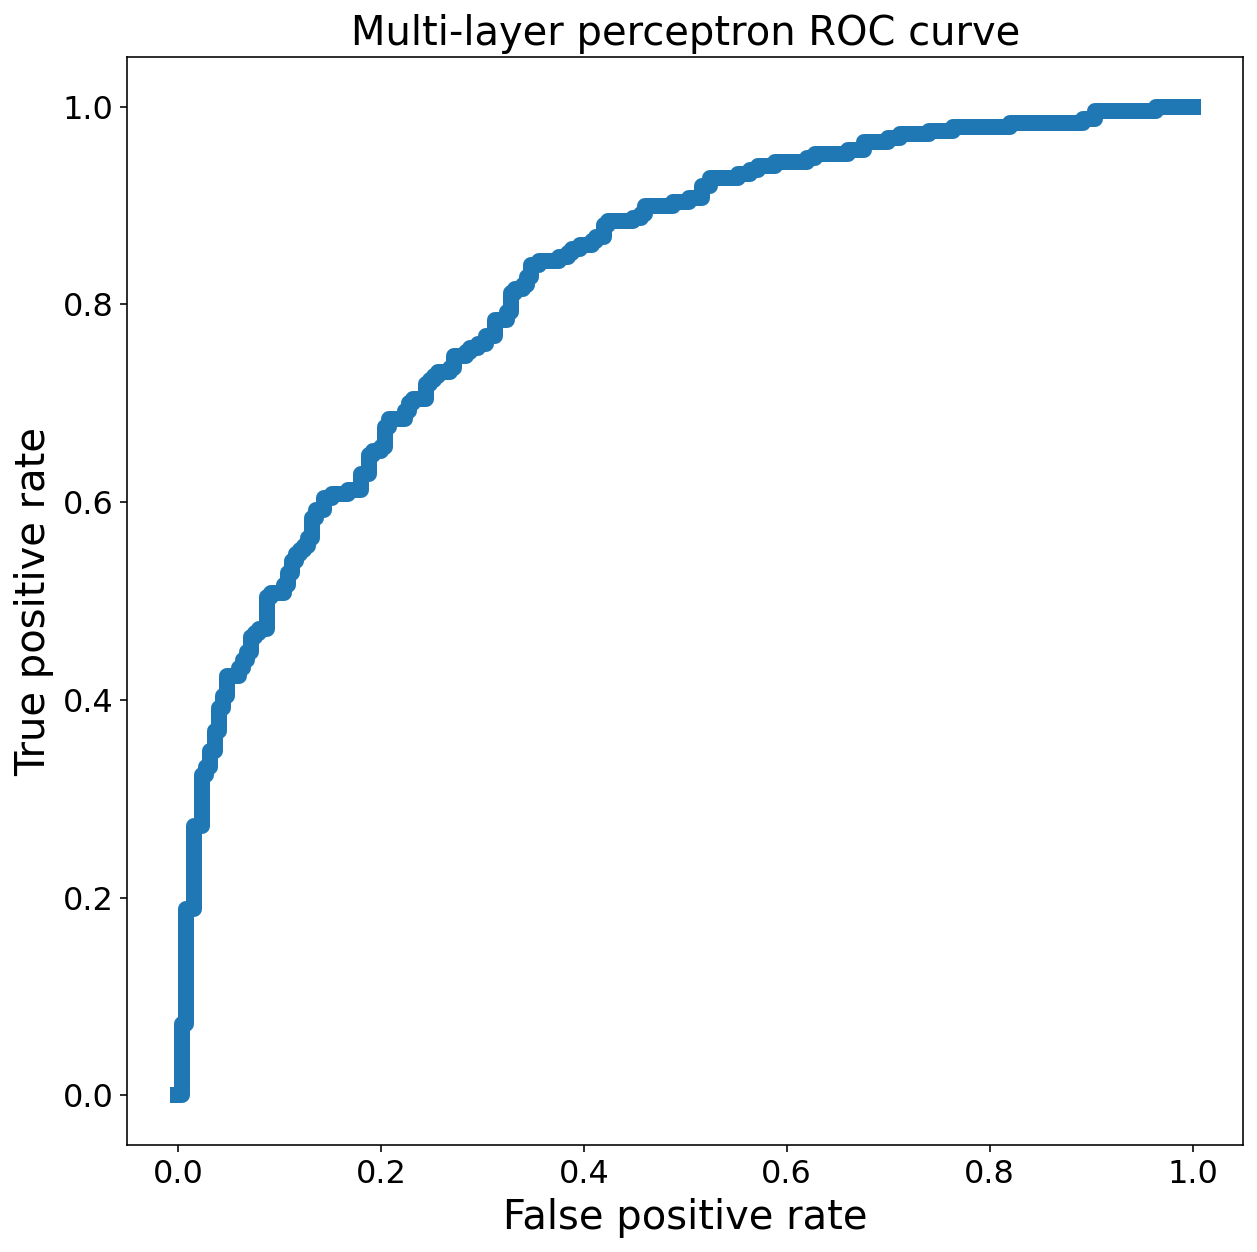

In [23]:
plt.figure(figsize=(10, 10))
plt.xlabel("False positive rate", fontsize=20)
plt.ylabel("True positive rate", fontsize=20)
plt.title("Multi-layer perceptron ROC curve", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(fpr, tpr, linewidth=8);

### (e) Automated hyperparameter search through random search

In [24]:
# Convert each pair in node_layer_pairs to the correct form to
#.  pass to the constructor for MLPClassifier
architectures = []
for pair in node_layer_pairs:
    nodes = pair[0]
    layers = pair[1]
    architecture = [nodes for i in range(layers)]
    architecture = tuple(architecture)
    architectures.append(architecture)

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

mlp = MLPClassifier()

# The distributions of hyperparameters we want the random search algorithm to explore
param_dist = {
    "batch_size": batch_sizes,
    "hidden_layer_sizes": architectures,
    "learning_rate_init": loguniform(10e-5, 1),
    "alpha": loguniform(10e-8, 100)
}

# Create a RandomizedSearch object and have it perform random search over the hyperparameters space
random_search = RandomizedSearchCV(mlp, param_distributions=param_dist,
                                  n_iter=200, cv=train_val_split)

# Fit the resulting model to the training and validation data
random_search.fit(X_train_plus_val, y_train_plus_val)

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=MLPClassifier(), n_iter=200,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f4ddb582220>,
                                        'batch_size': [1, 3, 5, 10, 20, 50, 100,
                                                       250, 500],
                                        'hidden_layer_sizes': [(1,), (1, 1),
                                                               (1, 1, 1),
                                                               (1, 1, 1, 1),
                                                               (2,), (2, 2),
                                                               (2, 2, 2),
                                                               (2, 2, 2, 2),
                                                               (3,), (3, 3),
                                                               (3, 3, 3),
                                                               (3, 3, 3, 3),
                                                               (4,), (4, 4),
                                                               (4, 4, 4),
                                                               (4, 4, 4, 4),
                                                               (5,), (5, 5),
                                                               (5, 5, 5),
                                                               (5, 5, 5, 5),
                                                               (10,), (10, 10),
                                                               (10, 10, 10),
                                                               (10, 10, 10, 10),
                                                               (15,), (15, 15),
                                                               (15, 15, 15),
                                                               (15, 15, 15, 15),
                                                               (25,), (25, 25), ...],
                                        'learning_rate_init': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f4ddbe86520>})

In [26]:
# The best hyperparameters from greedy search
greedy_lri = default_hyperparams[0]
greedy_architecture = default_hyperparams[1]
greedy_bs = default_hyperparams[8]
greedy_alpha = default_hyperparams[2]

# The best hyperparameters from random search
random_lri = random_search.best_params_["learning_rate_init"]
random_architecture = random_search.best_params_["hidden_layer_sizes"]
random_bs = random_search.best_params_["batch_size"]
random_alpha = random_search.best_params_["alpha"]

print(f"Optimal learning rate: (Greedy) {round(greedy_lri, 5)}, (Random search) {round(random_lri, 5)}")
print(f"Optimal batch size: (Greedy) {greedy_bs}, (Random search) {random_bs}")
print(f"Optimal architecture: (Greedy) {greedy_architecture}, (Random search) {random_architecture}")
print(f"Optimal regularization: (Greedy) {greedy_alpha}, (Random search) {random_alpha}")

Optimal learning rate: (Greedy) 0.01438, (Random search) 0.00059
Optimal batch size: (Greedy) 250, (Random search) 5
Optimal architecture: (Greedy) 30, (Random search) (10, 10, 10, 10)
Optimal regularization: (Greedy) 0.0018329807108324338, (Random search) 1.1029625276155354e-07


In [27]:
# Comparing test accuracy for greedy vs random search
greedy_mlp = make_new_default_model(default_hyperparams)
greedy_mlp.fit(X_train_plus_val, y_train_plus_val)
random_mlp = random_search

greedy_accuracy = greedy_mlp.score(X_test, y_test)
random_accuracy = random_mlp.score(X_test, y_test)

print(f"Greedy search test accuracy: {round(greedy_accuracy, 3)}")
print(f"Random search test accuracy: {round(random_accuracy, 3)}")

Greedy search test accuracy: 0.726
Random search test accuracy: 0.744


In [28]:
# Get probabilistic predictions for class 1 for each model
greedy_probs = greedy_mlp.predict_proba(X_test)[:,1]
random_probs = random_mlp.predict_proba(X_test)[:,1]

# Get false positive rates and true positive rates for each model
fpr_greedy, tpr_greedy, _ = roc_curve(y_test, greedy_probs)
fpr_random, tpr_random, _ = roc_curve(y_test, random_probs)

# Calculate AUC for each model
greedy_AUC = np.trapz(tpr_greedy, x=fpr_greedy)
random_AUC = np.trapz(tpr_random, x=fpr_random)

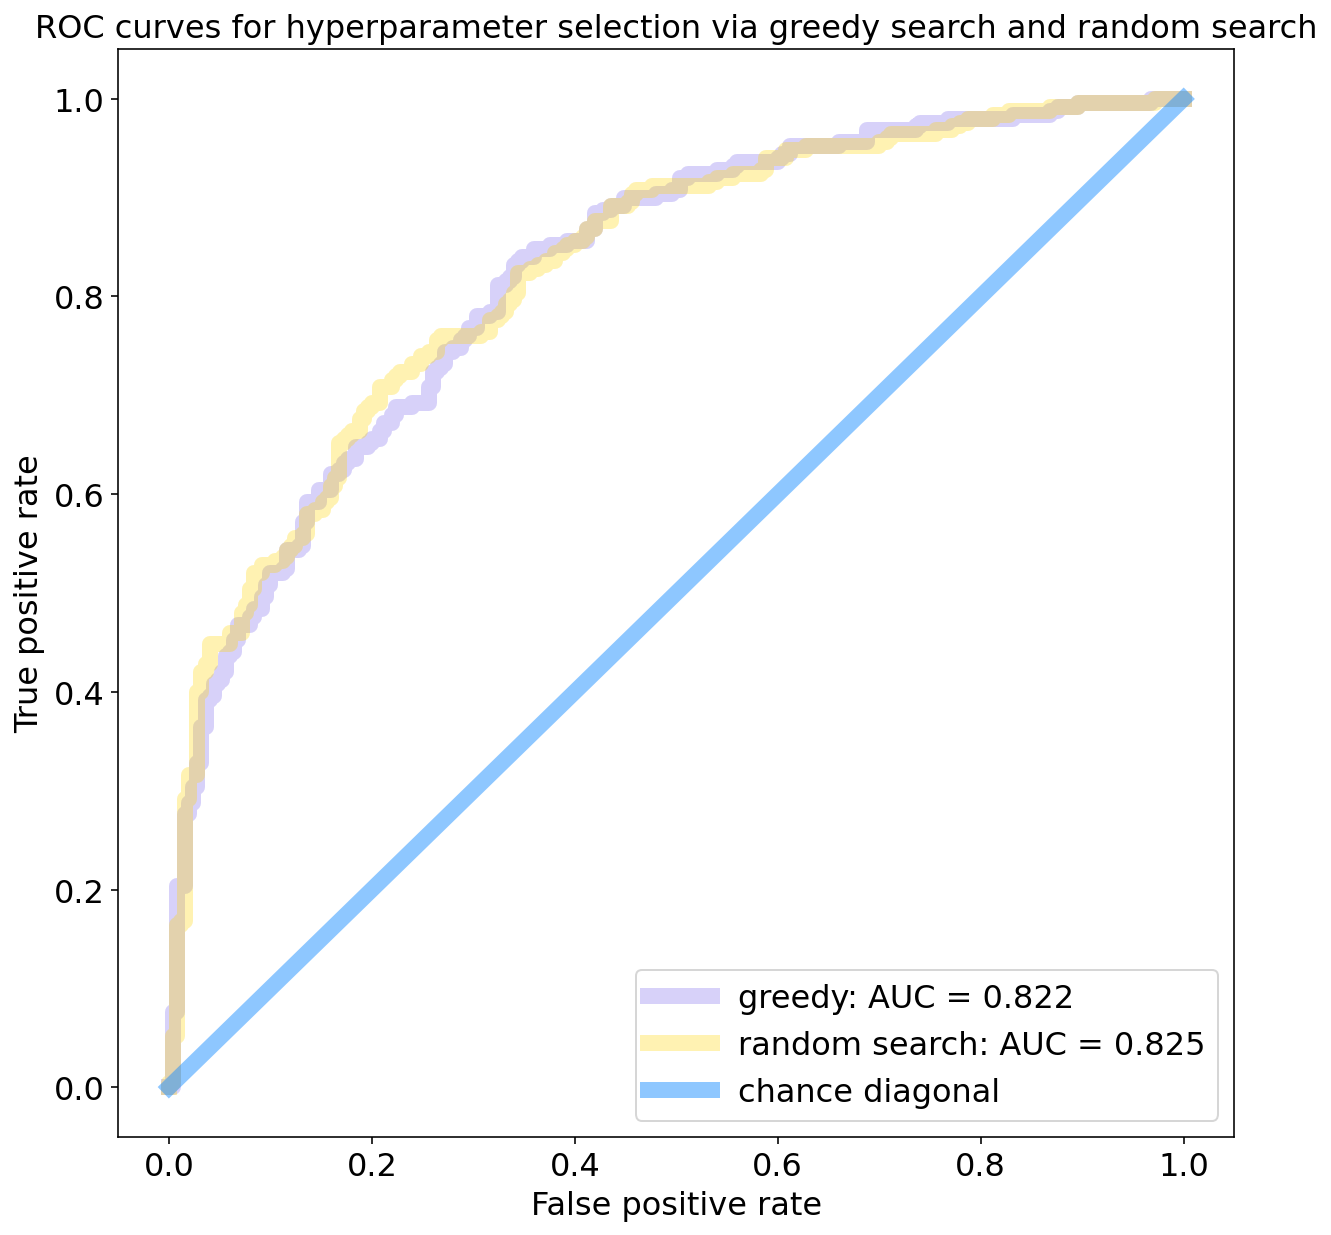

In [29]:
# Plotting ROC curves
plt.figure(figsize=(10,10))
plt.title("ROC curves for hyperparameter selection via greedy search and random search", fontsize=16)
plt.xlabel("False positive rate", fontsize=16)
plt.ylabel("True positive rate", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(fpr_greedy, tpr_greedy, label=f"greedy: AUC = {round(greedy_AUC, 3)}",
         linewidth=8, alpha=0.3, color="mediumslateblue");
plt.plot(fpr_random, tpr_random, label=f"random search: AUC = {round(random_AUC, 3)}",
         linewidth=8, alpha=0.3, color="gold");
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), label="chance diagonal",
        linewidth=8, alpha=0.5, color="dodgerblue")
plt.legend(prop = {"size": 16});

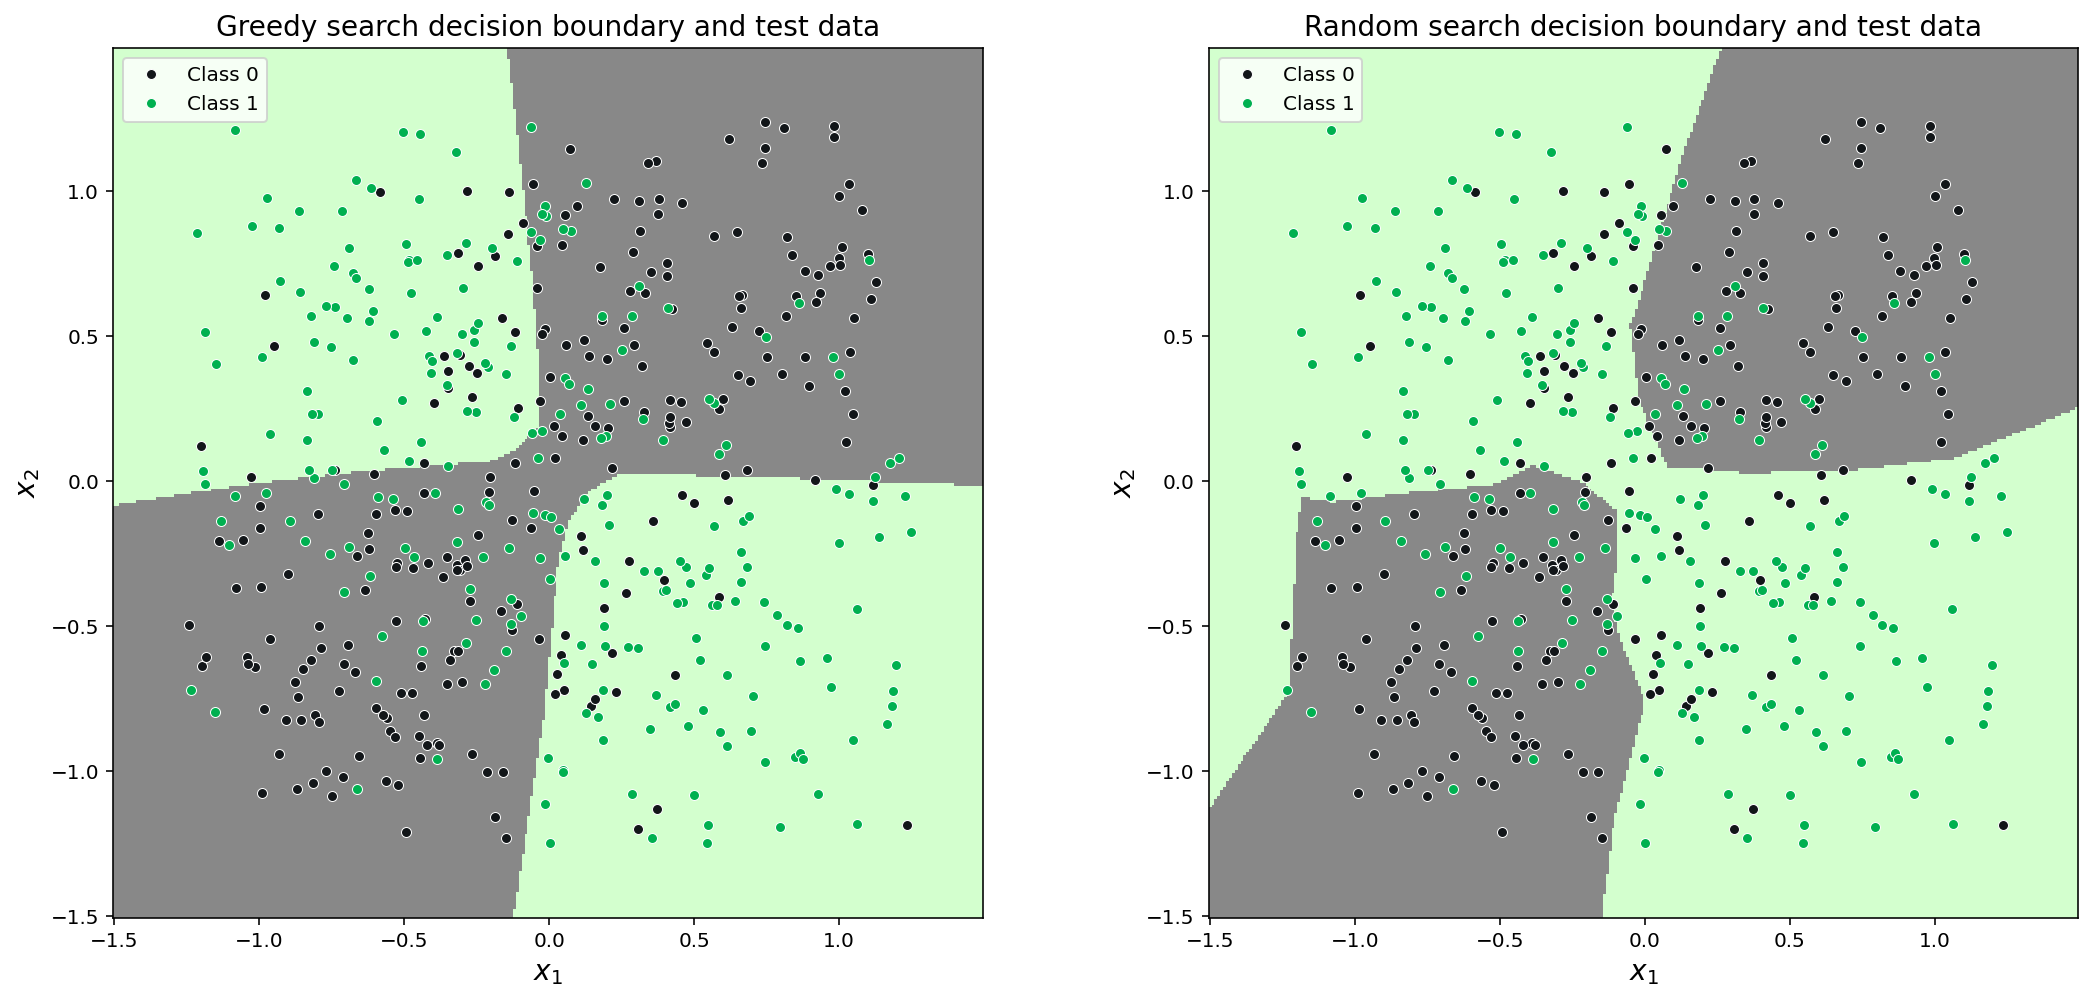

In [30]:
# Plotting decision boundaries
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
ax[0].pcolormesh(xx, yy, greedy_mlp.predict(grid).reshape(xx.shape), cmap=cmap);
ax[1].pcolormesh(xx, yy, random_mlp.predict(grid).reshape(xx.shape), cmap=cmap);

plot_data(ax[0], X_test, y_test, "Greedy search decision boundary and test data", limits)
plot_data(ax[1], X_test, y_test, "Random search decision boundary and test data", limits)

<font size="4">Greedy search and random search lead to very similar hyperparameter choices and very similar performance on test data. Greedy search resulted in 72.6% test accuracy 74.4% accuracy for random search. Both approaches achieve an AUC of 0.821 and have very similar decision boundaries.

## Section 2: Build and test a multi-layer perceptron from scratch

### (a) Create multi-layer perceptron from scratch

In [135]:
# Method descriptions for this class provided by course instructor, but I implemented all methods
class NN(object):
    
    def __init__(self, n_in=2, n_layer1=5, n_layer2=5, n_out=1, learning_rate=0.01, max_epochs=30):
        '''__init__
        Class constructor: Initialize the parameters of the network including
        the learning rate, layer sizes, and each of the parameters
        of the model (weights, placeholders for activations, inputs, 
        deltas for gradients, and weight gradients). This method
        should also initialize the weights of your model randomly
            Input:
                n_in:          number of inputs
                n_layer1:      number of nodes in layer 1
                n_layer2:      number of nodes in layer 2
                n_out:         number of output nodes
                learning_rate: learning rate for gradient descent
            Output:
                none
        '''
        # Initialize number of layers, number of nodes per layer, and learning rate
        self.n_in = n_in
        self.n_layer1 = n_layer1
        self.n_layer2 = n_layer2
        self.n_out = n_out
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        
        # Initialize all activations to 1 as placeholder value
        # Activation: Linear combination of inputs to a node and weights along the synapses leading to a node
        #.  The left-hand number in a node
        self.a1 = np.ones((self.n_layer1, 1))
        self.a2 = np.ones((self.n_layer2, 1))
        self.a3 = np.ones((self.n_out, 1))
        
        # Initialize all node outputs to 1 as placeholder value
        # Node output: The right-hand number in a node
        self.z0 = np.ones((self.n_in, 1))
        self.z1 = np.ones((self.n_layer1, 1))
        self.z2 = np.ones((self.n_layer2, 1))
        self.z3 = np.ones((self.n_out, 1))
        
        # Randomly initialize model weights
        np.random.seed(0)
        self.w1 = np.random.rand(self.n_layer1, self.n_in)
        self.w2 = np.random.rand(self.n_layer2, self.n_layer1)
        self.w3 = np.random.rand(self.n_out, self.n_layer2)
        
        # Initialize all deltas to 1
        # Delta: derivative of cost with respect to an activation
        self.d1 = np.ones((self.n_layer1, 1))
        self.d2 = np.ones((self.n_layer2, 1))
        self.d3 = np.ones((self.n_out, 1))
        
        # Initialize all gammas to 1
        # Gamma: derivative of cost with respect to a node output
        self.g0 = np.ones((self.n_in, 1))
        self.g1 = np.ones((self.n_layer1, 1))
        self.g2 = np.ones((self.n_layer2, 1))
        self.g3 = np.ones((self.n_out, 1))
        
        # Initialize all weight gradients to 1
        self.weight_grad1 = np.ones((self.n_layer1, self.n_in))
        self.weight_grad2 = np.ones((self.n_layer2, self.n_layer1))
        self.weight_grad3 = np.ones((self.n_out, self.n_layer2))
            
    def forward_propagation(self, x):
        '''forward_propagation
        Takes a vector of your input data (one sample) and feeds
        it forward through the neural network, calculating activations and
        layer node values along the way.
            Input:
                x: a vector of data representing 1 sample [n_in x 1]
            Output:
                y_hat: a vector (or scaler of predictions) [n_out x 1]
                (typically n_out will be 1 for binary classification)
        '''
        # Calculate node values and activations for the first hidden layer
        self.a1 = self.w1 @ x
        self.z1 = self.sigmoid(self.a1)
        # Calculate node values and activations for the second hidden layer
        self.a2 = self.w2 @ self.z1
        self.z2 = self.sigmoid(self.a2)
        #Calculate output layer node values and the actual output (a probabilistic prediction)
        self.a3 = self.w3 @ self.z2
        self.z3 = self.sigmoid(self.a3)
        return self.z3
    
    def predict_proba(self, X):
        '''predict_proba
        Compute the output of the neural network for each sample in X, with the last layer's
        sigmoid activation providing an estimate of the target output between 0 and 1
            Input:
                X: A matrix of N samples of data [N x n_in]
            Output:
                y_hat: A vector of class predictions between 0 and 1 [N x 1]
        '''
        return np.apply_along_axis(self.forward_propagation, 1, X)
    
    def predict(self, X, decision_thresh=0.5):
        '''predict
        Compute the output of the neural network prediction for 
        each sample in X, with the last layer's sigmoid activation 
        providing an estimate of the target output between 0 and 1, 
        then thresholding that prediction based on decision_thresh
        to produce a binary class prediction
            Input:
                X: A matrix of N samples of data [N x n_in]
                decision_threshold: threshold for the class confidence score
                                    of predict_proba for binarizing the output
            Output:
                y_hat: A vector of class predictions of either 0 or 1 [N x 1]
        '''
        probs = self.predict_proba(X)
        return np.array([1 if prob > decision_thresh else 0 for prob in probs]).reshape(-1, 1)
    
    def compute_loss(self, X, y):
        '''compute_loss
        Computes the current loss/cost function of the neural network
        based on the weights and the data input into this function.
        To do so, it runs the X data through the network to generate
        predictions, then compares it to the target variable y using
        the cost/loss function
            Input:
                X: A matrix of N samples of data [N x n_in]
                y: Target variable [N x 1]
            Output:
                loss: a scalar measure of loss/cost
        '''
        probs = self.predict_proba(X)
        N = X.shape[0]
        total_MSE = np.sum(0.5 * ((y - probs) ** 2))
        average_MSE = (1 / N) * total_MSE
        return average_MSE
    
    def sigmoid(self, X):
        '''sigmoid
        Compute the sigmoid function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid function
        '''
        return 1 / (1 + np.exp(-1 * X))
    
    def sigmoid_derivative(self, X):
        '''sigmoid_derivative
        Compute the sigmoid derivative function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid derivative function
        '''
        return self.sigmoid(X) * (1 - self.sigmoid(X))
    
    def backpropagate(self, x, y):
        '''backpropagate
        Backpropagate the error from one sample determining the gradients
        with respect to each of the weights in the network. The steps for
        this algorithm are:
            1. Run a forward pass of the model to get the activations 
               Corresponding to x and get the loss functionof the model 
               predictions compared to the target variable y
            2. Compute the deltas (see lecture notes) and values of the
               gradient with respect to each weight in each layer moving
               backwards through the network
    
            Input:
                x: A vector of 1 samples of data [n_in x 1]
                y: Target variable [scalar]
            Output:
                loss: a scalar measure of th loss/cost associated with x,y
                      and the current model weights
        '''
        # Step 0: Compute loss for the single sample x
        err = self.compute_loss(x.reshape(1, 2), y)
        
        # Step 1: Gamma 3: Derivative of loss w.r.t z3
        self.g3 = self.z3 - y
        
        # Step 2: Delta 3: Derivative of loss w.r.t a3
        self.d3 = self.g3 * self.sigmoid_derivative(self.a3)
        
        # Step 3: Gamma 2: Derivative of loss w.r.t z2
        self.g2 = (self.d3 * self.w3).reshape(-1, 1)
        
        # Step 4: Delta 2: Derivative of loss w.r.t a2
        self.d2 = self.g2 * self.sigmoid_derivative(self.a2).reshape(-1, 1)
        
        # Step 5: Gamma 1: Derivative of loss w.r.t z2
        self.g1 = self.w2.T @ self.d2
        
        # Step 6: Delta 1: Derivative of loss w.r.t a2
        self.d1 = self.g1 * self.sigmoid_derivative(self.a1).reshape(-1, 1)
        
        # Step 7: Gamma 0: Derivative of loss w.r.t input
        self.g0 = self.w1.T @ self.d1
        
        # Step 8: Derivative of loss w.r.t each of the weights
        self.weight_grad3 = self.d3.reshape(-1, 1) @ self.z2.reshape(1, -1)
        self.weight_grad2 = self.d2.reshape(5, -1) @ self.z1.reshape(-1, 5)
        self.weight_grad1 = self.d1 @ x.T
        
        # Step 9: Stochastic gradient descent
        self.w1 = self.w1 - (self.learning_rate * self.weight_grad1)
        self.w2 = self.w2 - (self.learning_rate * self.weight_grad2)
        self.w3 = self.w3 - (self.learning_rate * self.weight_grad3)
        
    def fit(self, X_train, y_train, X_val, y_val, learning_rate=0.01):
        '''fit
            Input:
                X_train: A matrix of N samples of data [N x n_in]
                y_train: Target variable [N x 1]
                X_val: A matrix of N samples of data [N x n_in]
                y_val: Target variable [N x 1]
            Output:
                training_loss:   Vector of training loss values at the end of each epoch
                validation_loss: Vector of validation loss values at the end of each epoch
        '''
        training_loss = []
        validation_loss = []
        epoch = 0
        while epoch < self.max_epochs:
            # Run a step of stochastic gradient descent for each training sample
            for i in range(X_train.shape[0]):
                x = X_train[i].reshape(-1, 1)
                y_true = y_train[i]
                self.backpropagate(x, y_true)
            # Calculate training loss at the end of the epoch
            training_loss.append(self.compute_loss(X_train, y_train))
            validation_loss.append(self.compute_loss(X_val, y_val))
            epoch += 1
        return training_loss, validation_loss
            
    def reset(self):
        """
        Reset all the weights randomly
        """
        np.random.seed(0)
        self.w1 = np.random.rand(self.n_layer1, self.n_in)
        self.w2 = np.random.rand(self.n_layer2, self.n_layer1)
        self.w3 = np.random.rand(self.n_out, self.n_layer2)
        
    def score(self, X, y):
        N = y.shape[0]
        predictions = self.predict(X)
        diff = np.abs(predictions - y)
        total_misclassified = np.sum(diff)
        num_correct = N - total_misclassified
        return num_correct / N

### (b) Apply the neural network

In [118]:
# Importing the data
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import pandas as pd

X, y = make_moons(600, noise=0.20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state = 43)

# Create validation set
X_val = X_train[400:]
y_val = y_train[400:]

# Drop validation set out of the training set
X_train = X_train[:400]
y_train = y_train[:400]

# Make each set of labels a column vector
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Train a model
nn = NN()
training_loss, validation_loss = nn.fit(X_train, y_train, X_val, y_val)

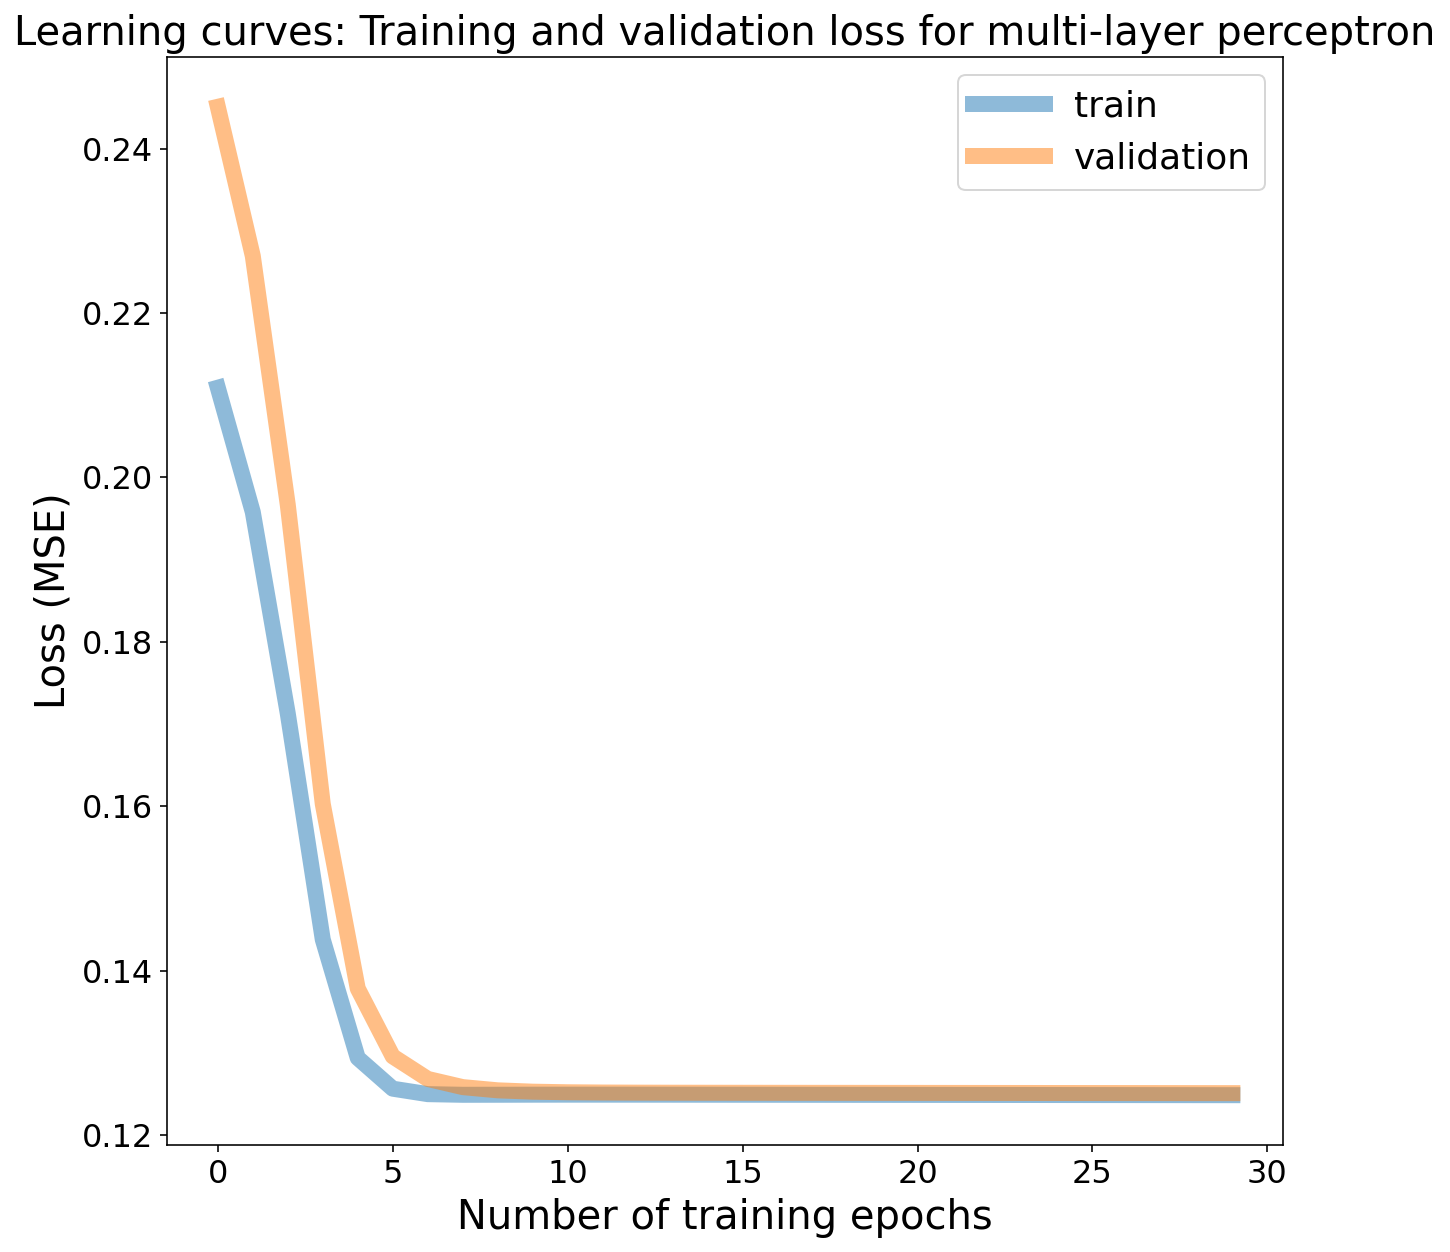

In [119]:
# Plotting learning curves
plt.figure(figsize=(10, 10))
plt.title("Learning curves: Training and validation loss for multi-layer perceptron",
          fontsize=20)
plt.xlabel("Number of training epochs", fontsize=20)
plt.ylabel("Loss (MSE)", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(np.arange(nn.max_epochs), training_loss, label="train",
         linewidth=8, alpha=0.5);
plt.plot(np.arange(nn.max_epochs), validation_loss, label="validation",
         linewidth=8, alpha=0.5);
plt.legend(prop = {"size": 18});

<font size="4">Now let's use grid search to tune two hyperparameters of our neural network: learning rate and number of training epochs.

In [120]:
def grid_search(param_pairs, X_train, X_val, y_train, y_val):
    """Implement grid search for tuning two hyperparameters of a NN
        Input:
            param_pairs: a list of lists, where each inner list is pair of hyperparameters
            X_Train: ndarray - training samples
            X_val: ndarray - validation samples
            y_train: ndarray (column vector) - training labels
            y_val: ndarray (column vector) - validation labels
        Output:
            best_pair: The pair from param_pairs that allows the NN to
                       perform the best on the validation data
    """
    accuracies = []
    for pair in param_pairs:
        model = NN()
        model.learning_rate = pair[0]
        model.max_epochs = pair[1]
        model.fit(X_train, y_train, X_val, y_val)
        accuracy = model.score(X_val, y_val)
        accuracies.append(accuracy)
    return np.array(accuracies)

In [121]:
# Build a list of learning_rate, max_epochs pairs to do grid search over
learning_rates_arr = np.logspace(-5, 0, 20)
max_epochs_arr = [1, 2, 3, 5, 10, 20, 30, 50]

param_pairs = []
for lr in learning_rates_arr:
    for epoch in max_epochs_arr:
        pair = [lr, epoch]
        param_pairs.append(pair)

In [122]:
# Find the best pair of hyperparameters
accuracies = grid_search(param_pairs, X_train, X_val, y_train, y_val)

In [123]:
idx_max = np.argmax(accuracies)
best_pair = param_pairs[idx_max]
best_lr = best_pair[0]
best_epoch = best_pair[1]

print(f"Optimal learning_rate: {best_lr}")
print(f"Optimal max_epochs: {best_epoch}")

Optimal learning_rate: 1.0
Optimal max_epochs: 3


In [124]:
# Train the tuned network
tuned_nn = NN(learning_rate=best_lr, max_epochs=best_epoch)
_,_ = tuned_nn.fit(X_train, y_train, X_val, y_val)

<font size="4">Now let's plot the decision boundary for our tuned network on the half moons dataset.

In [125]:
# Organize the data for plotting
train_df = pd.DataFrame(data=X_train, columns=["x1", "x2"])
train_df["y"] = y_train

val_df = pd.DataFrame(data=X_val, columns=["x1", "x2"])
val_df["y"] = y_val

train_class_0 = train_df[train_df["y"] == 0]
train_class_1 = train_df[train_df["y"] == 1]

val_class_0 = val_df[val_df["y"] == 0]
val_class_1 = val_df[val_df["y"] == 1]

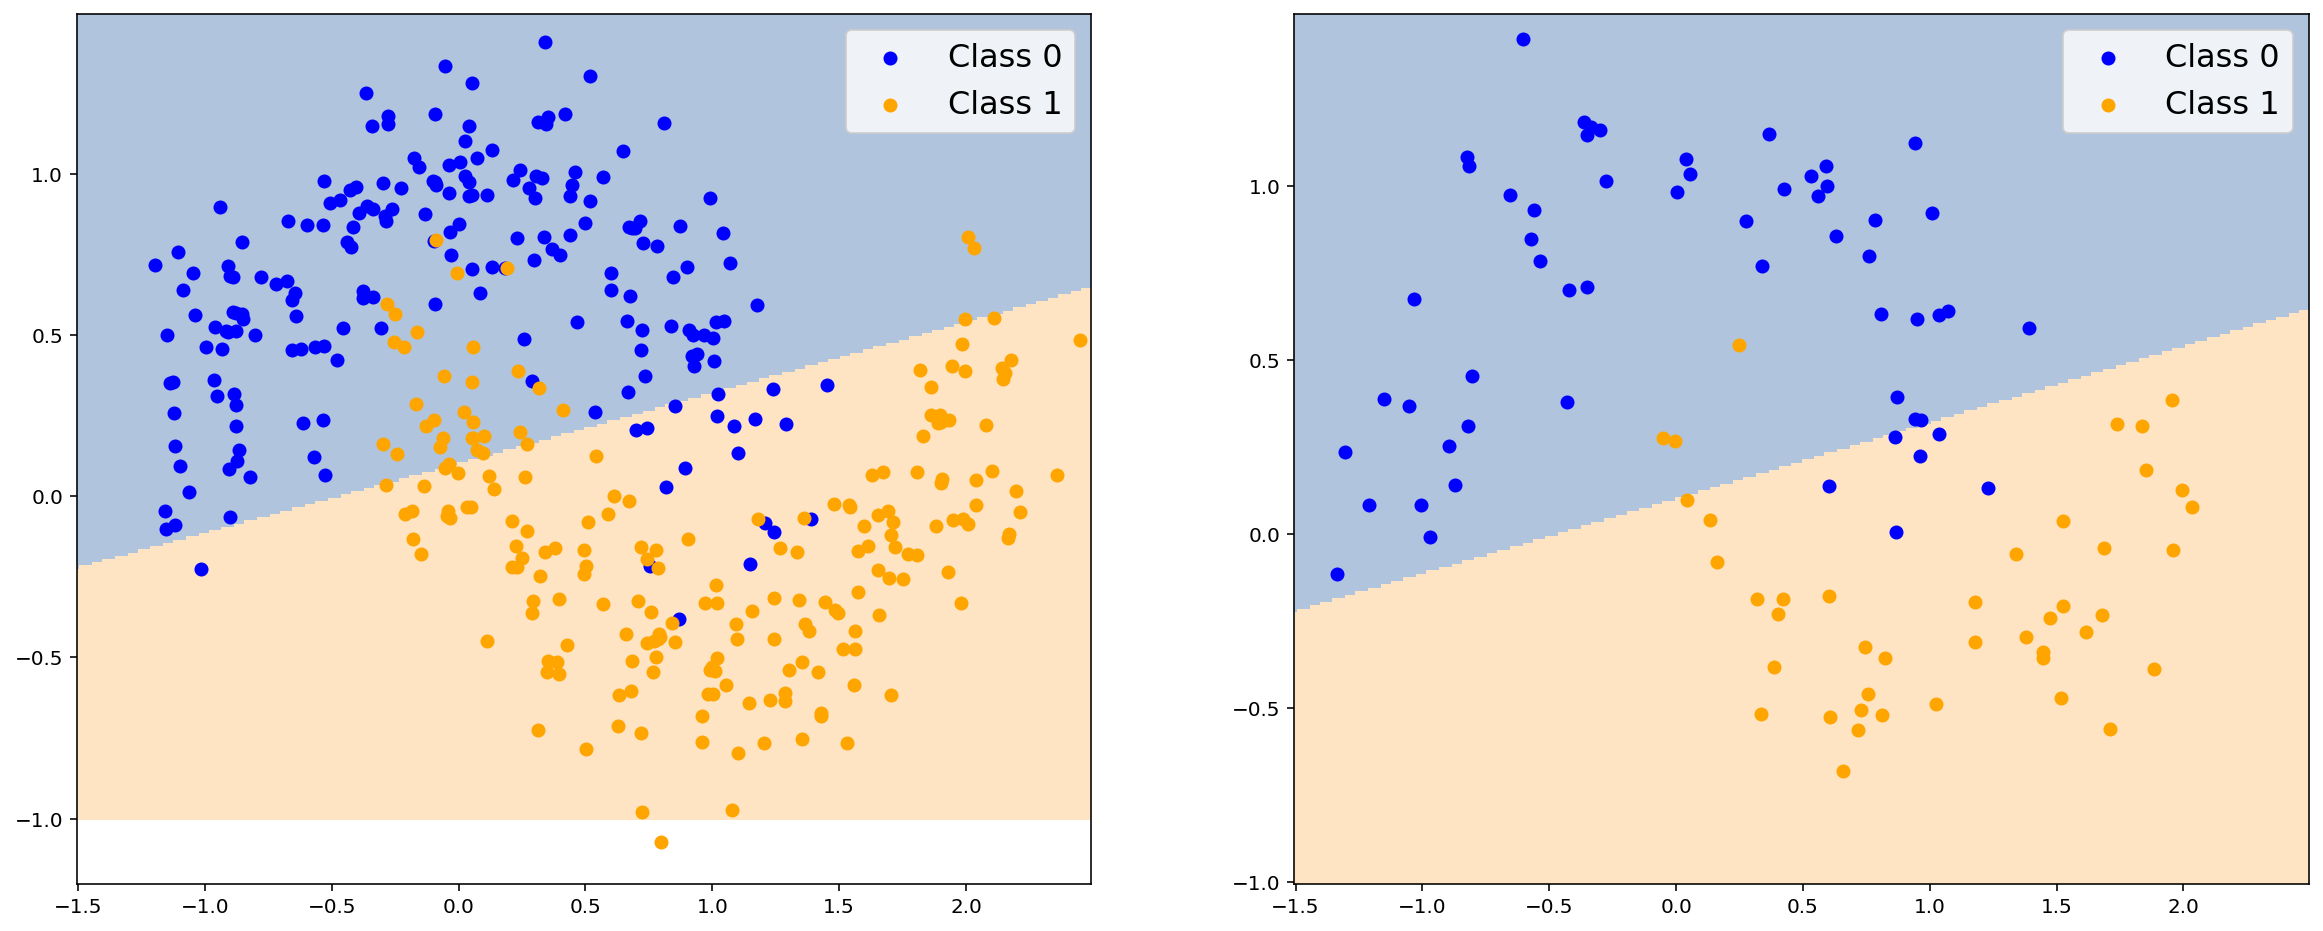

In [126]:
# Plot training data along with decision boundary
# Also plot validation data along with decision boundary
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

cmap = ListedColormap(["lightsteelblue", "bisque"])

# Create a mesh
x_min = -1.5
x_max = 2.5
y_min = -1
y_max = 1.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
grid = np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)

ax[0].pcolormesh(xx, yy, tuned_nn.predict(grid).reshape(xx.shape), cmap=cmap);
ax[1].pcolormesh(xx, yy, tuned_nn.predict(grid).reshape(xx.shape), cmap=cmap);

ax[0].scatter(train_class_0["x1"], train_class_0["x2"], color="b", label="Class 0");
ax[0].scatter(train_class_1["x1"], train_class_1["x2"], color="orange", label="Class 1");
ax[0].legend(prop={"size": 16});

ax[1].scatter(val_class_0["x1"], val_class_0["x2"], color="b", label="Class 0");
ax[1].scatter(val_class_1["x1"], val_class_1["x2"], color="orange", label="Class 1");
ax[1].legend(prop={"size": 16});

<font size="4">Finally, let's assess the performance of the tuned model on the held-out test set.

In [127]:
# Get fprs and tprs for our from-scratch model
predicted_probs_from_scratch = tuned_nn.predict_proba(X_test)
fpr_from_scratch, tpr_from_scratch, _ = roc_curve(y_test, predicted_probs_from_scratch)

# Get fprs and tprs for sklearn's MLPClassifier
mlp = MLPClassifier(learning_rate_init=best_lr,
                    max_iter=best_epoch,
                    hidden_layer_sizes=(5, 5),
                    solver="sgd"
                   )
mlp.fit(X_train, y_train)
predicted_probs_sklearn = mlp.predict_proba(X_test)
fpr_sklearn, tpr_sklearn, _ = roc_curve(y_test, predicted_probs_sklearn[:,1])

from sklearn.metrics import roc_auc_score

# Calculate AUROC for each model
AUC_from_scratch = round(roc_auc_score(y_test, predicted_probs_from_scratch), 2)
AUC_sklearn = round(roc_auc_score(y_test, predicted_probs_sklearn[:,1]), 2)

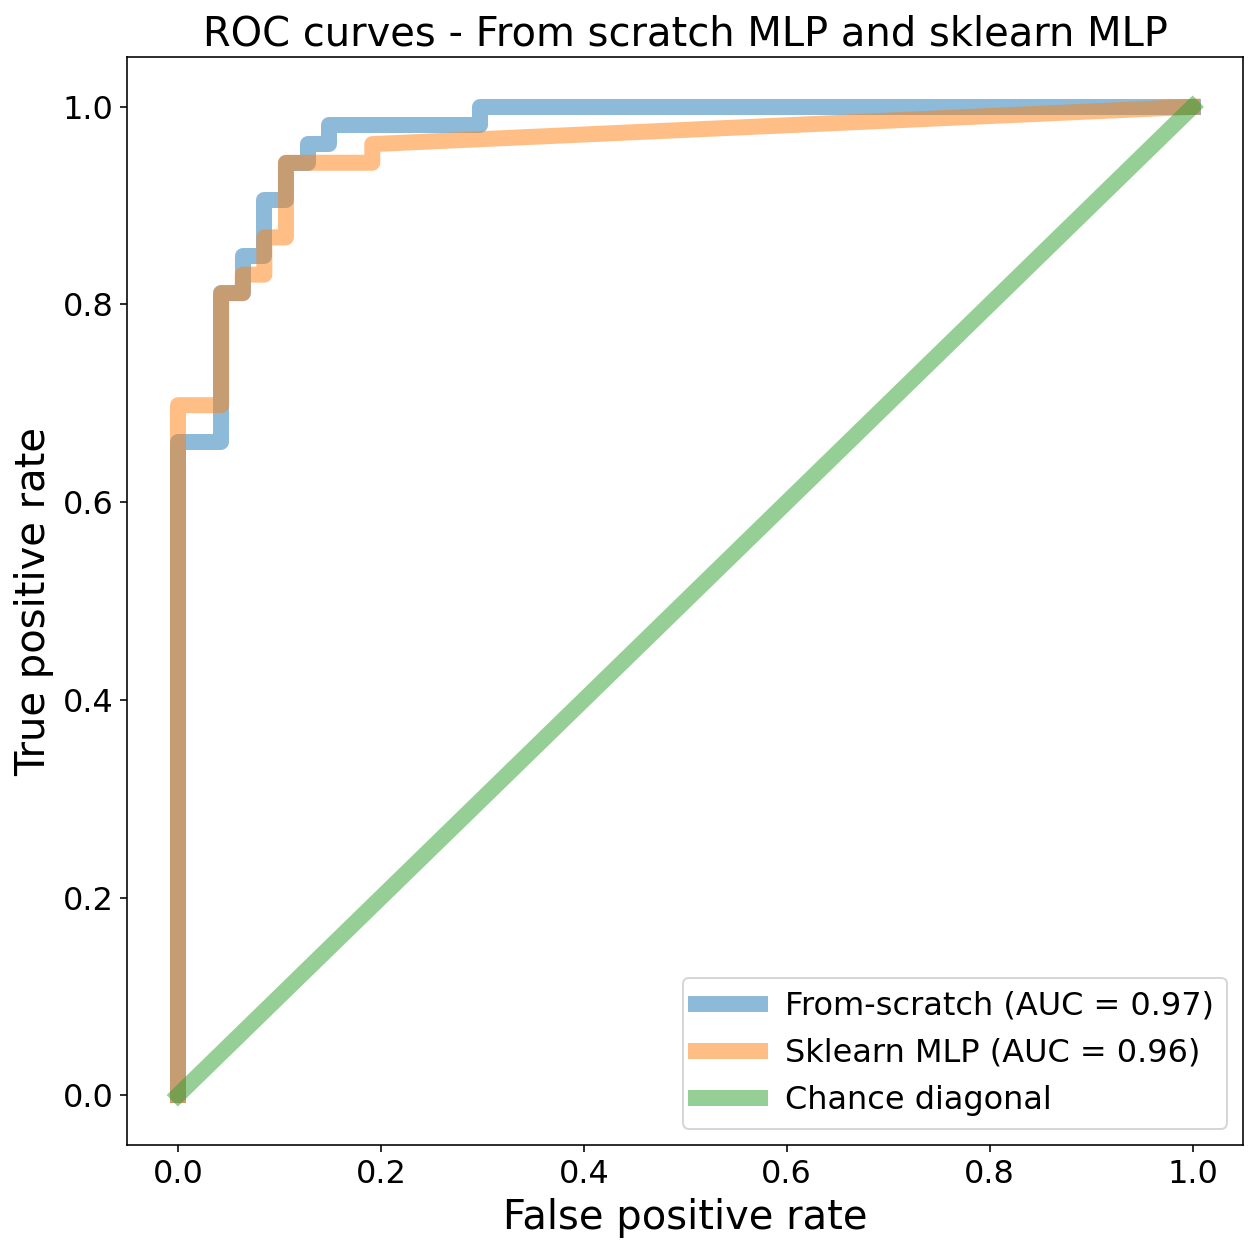

In [128]:
# Plot ROC curves
plt.figure(figsize=(10, 10))
plt.xlabel("False positive rate", fontsize=20)
plt.ylabel("True positive rate", fontsize=20)
plt.title("ROC curves - From scratch MLP and sklearn MLP", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(fpr_from_scratch, tpr_from_scratch, linewidth=8, alpha=0.5,
         label=f"From-scratch (AUC = {AUC_from_scratch})");
plt.plot(fpr_sklearn, tpr_sklearn, linewidth=8, alpha=0.5,
         label=f"Sklearn MLP (AUC = {AUC_sklearn})");
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linewidth=8,
         alpha=0.5, label = "Chance diagonal");
plt.legend(prop = {"size": 16});

### (3) Potential model improvements

<font size="4">Our from-scratch multi-layer perceptron class could be improved by introducing some form of regularization, such as dropout (only make use of some random subset of the neurons in the model). We could also optimize the activation functions we use, perhaps trying out ReLU or GELU instead of the sigmoid activation function. We could even use different activation functions for different layers.